In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as plot
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


In [2]:
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
data = pd.read_csv('titanic_data.csv')

### Exploratory Data Analysis 

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
print(data.shape)

(891, 12)


In [6]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


There are missing values in Age. Out of 891 only 714 are present. Hence they need to be imputed

In [7]:
data['Age'] = data['Age'].fillna(data['Age'].median())  #imputed with median age

In [8]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
data['Died'] = 1 - data['Survived']

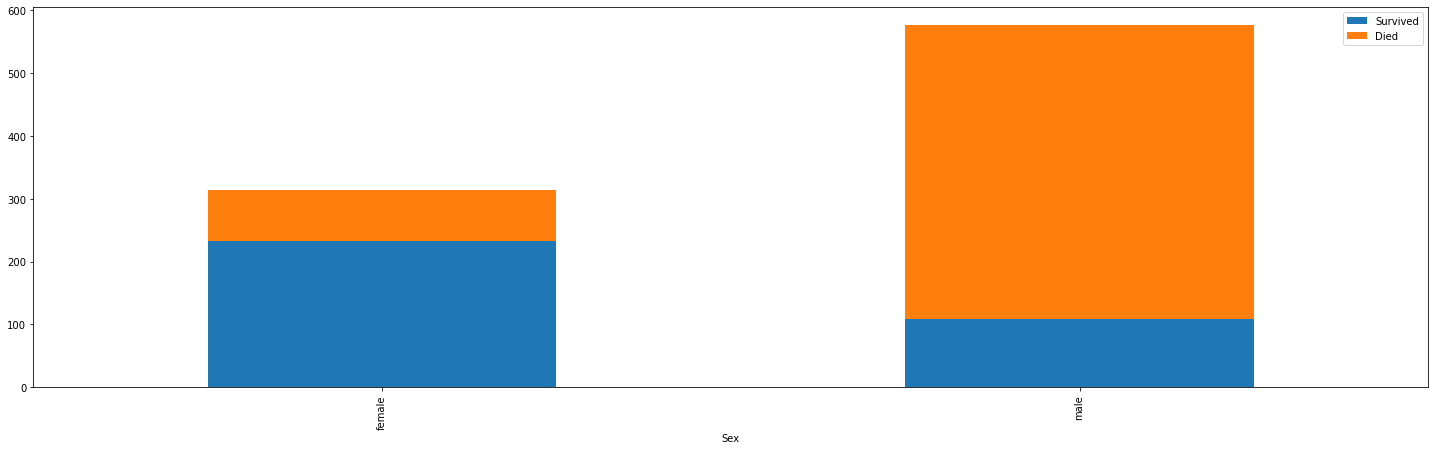

In [10]:
data.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7),stacked=True)

At first glance, it seems male passengers are more likely to survive from total count

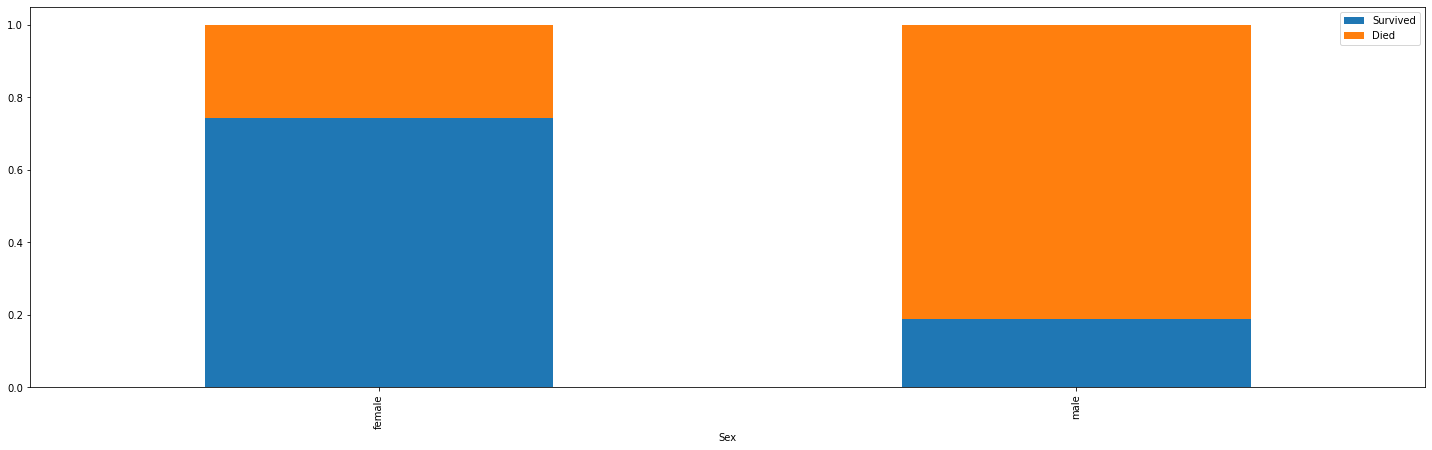

In [11]:
data.groupby('Sex').agg('mean')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7), stacked=True)

Taking ratio it is seen that a female is more likely to survive......we cannot directly assume looking at the total numbers

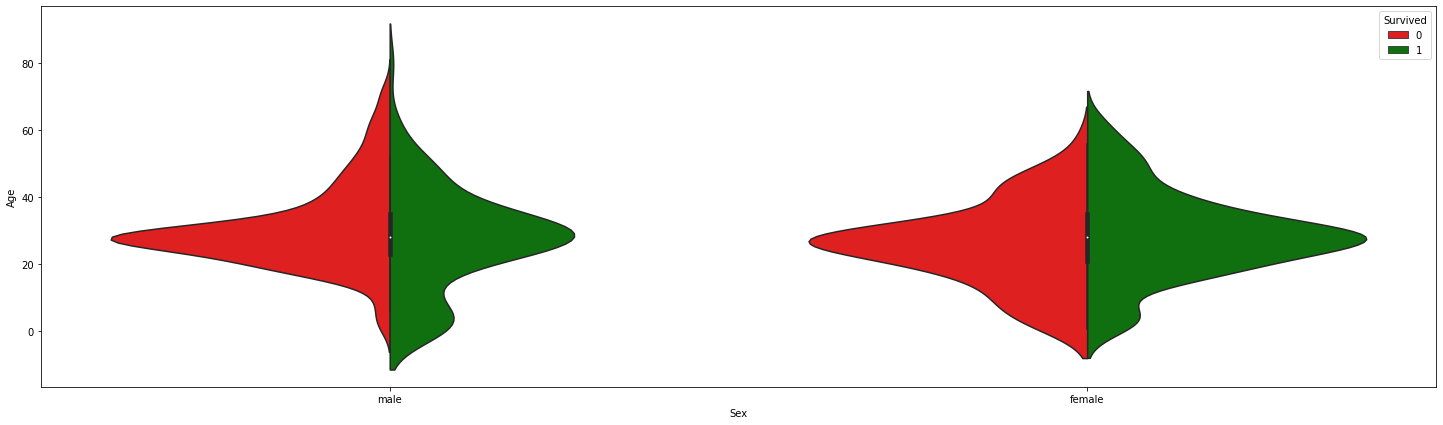

In [12]:
fig = plt.figure(figsize=(25, 7))
sns.violinplot(x='Sex', y='Age', 
               hue='Survived', data=data, 
               split=True,
               palette={0: "r", 1: "g"}
              );

In males the survival is more in young people ---- two peaks in the green [0 to 20]years and [20 to 40]years; But in females age did not show such impact.  

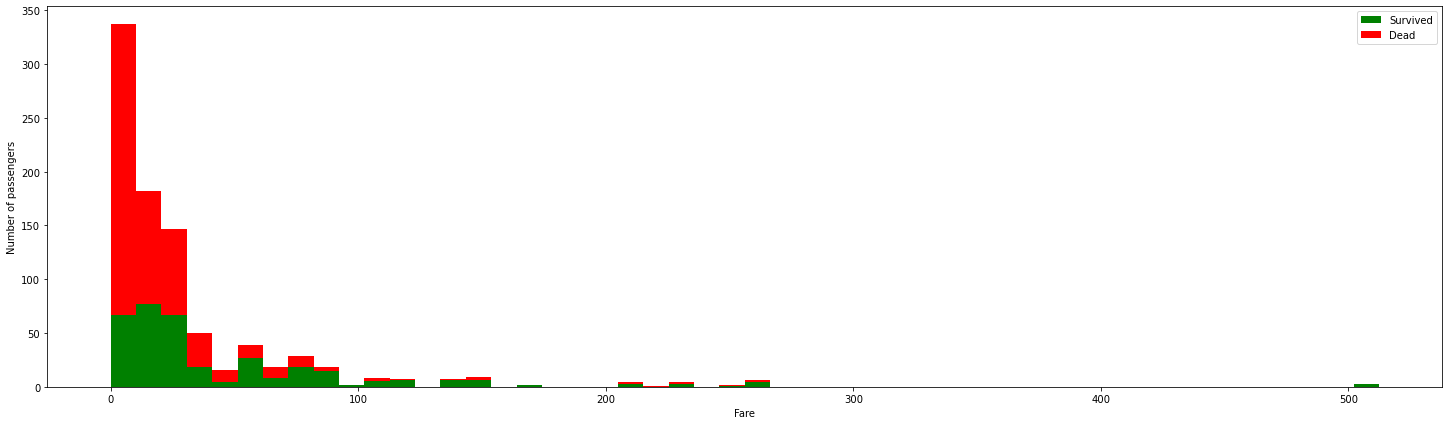

In [13]:
#Impact of Ticket Fares
figure = plt.figure(figsize=(25, 7))
plt.hist([data[data['Survived'] == 1]['Fare'], data[data['Survived'] == 0]['Fare']], 
         stacked=True, color = ['g','r'],
         bins = 50, label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

It is seen that most people dead belonged to passengers with low fares 

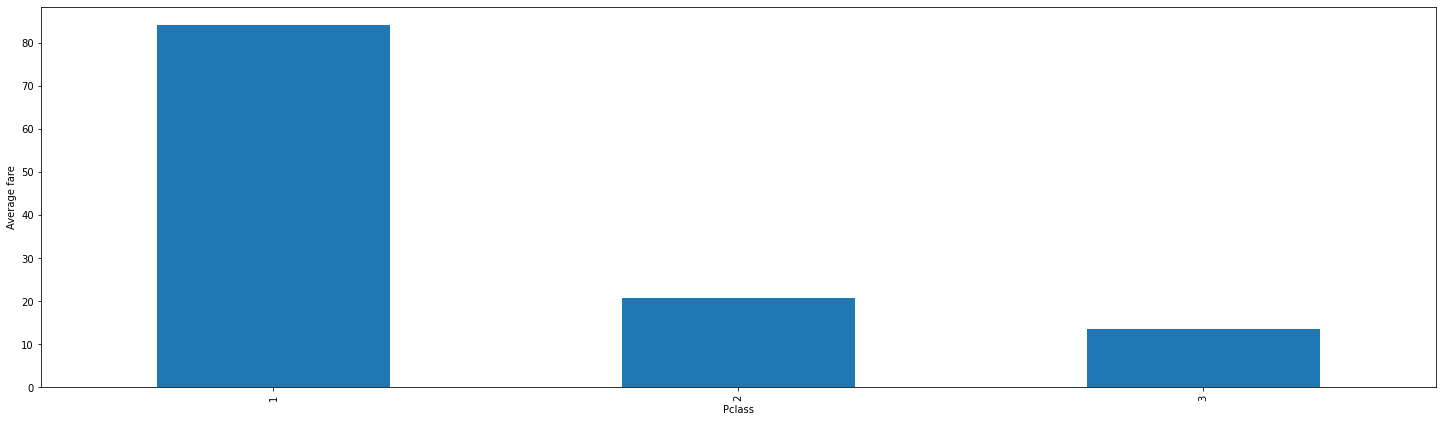

In [14]:
ax = plt.subplot()
ax.set_ylabel('Average fare')
data.groupby('Pclass').mean()['Fare'].plot(kind='bar', figsize=(25, 7), ax = ax)

The ticket fare correlates with the class as we see it in the chart above.

## Data preprocessing, Model Building and Prediction

As seen from the Data it is a binary classification problem --- Survived or Died

In [15]:
data 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Died
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,NaN,S,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0


In [16]:
cols = ['Name','Ticket','Cabin','PassengerId']
titanic_DT= data
titanic_DT = titanic_DT.drop(cols,axis=1)
titanic_DT.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Died
0,0,3,male,22.0,1,0,7.2500,S,1
1,1,1,female,38.0,1,0,71.2833,C,0
2,1,3,female,26.0,0,0,7.9250,S,0
3,1,1,female,35.0,1,0,53.1000,S,0
4,0,3,male,35.0,0,0,8.0500,S,1


Droping some of the columns which many not contribute much to our machine learning model such as Name, Ticket, Cabin etc

In [19]:
#Now we convert the Pclass, Sex, Embarked to columns in pandas and drop them after conversion.
dummies = []
cols = ['Pclass','Sex','Embarked']
for col in cols:
    dummies.append(pd.get_dummies(titanic_DT[col]))

In [21]:
titanic_dummies = pd.concat(dummies, axis=1)
titanic_dummies.head()

,1,2,3,female,male,C,Q,S
0,0,0,1,0,1,0,0,1
1,1,0,0,1,0,1,0,0
2,0,0,1,1,0,0,0,1
3,1,0,0,1,0,0,0,1
4,0,0,1,0,1,0,0,1


In [22]:
# Concating it to the original Dataset
titanic_DT = pd.concat((titanic_DT,titanic_dummies),axis=1)

In [23]:
titanic_DT.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Died,1,2,3,female,male,C,Q,S
0,0,3,male,22.0,1,0,7.2500,S,1,0,0,1,0,1,0,0,1
1,1,1,female,38.0,1,0,71.2833,C,0,1,0,0,1,0,1,0,0
2,1,3,female,26.0,0,0,7.9250,S,0,0,0,1,1,0,0,0,1
3,1,1,female,35.0,1,0,53.1000,S,0,1,0,0,1,0,0,0,1
4,0,3,male,35.0,0,0,8.0500,S,1,0,0,1,0,1,0,0,1


We need to drop the redundant columns

In [24]:
titanic_DT = titanic_DT.drop(['Pclass','Sex','Embarked','Died'],axis=1)
titanic_DT.head()

,Survived,Age,SibSp,Parch,Fare,1,2,3,female,male,C,Q,S
0,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,1,0,0,0,1
4,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


In [25]:
titanic_DT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Age       891 non-null    float64
 2   SibSp     891 non-null    int64  
 3   Parch     891 non-null    int64  
 4   Fare      891 non-null    float64
 5   1         891 non-null    uint8  
 6   2         891 non-null    uint8  
 7   3         891 non-null    uint8  
 8   female    891 non-null    uint8  
 9   male      891 non-null    uint8  
 10  C         891 non-null    uint8  
 11  Q         891 non-null    uint8  
 12  S         891 non-null    uint8  
dtypes: float64(2), int64(3), uint8(8)
memory usage: 41.9 KB


In [26]:
y = titanic_DT['Survived'].values   #the target column

In [27]:
# The variables array X 
titanic_ml= titanic_DT.drop(['Survived'],1)
X = titanic_ml.values
titanic_ml.head()

,Age,SibSp,Parch,Fare,1,2,3,female,male,C,Q,S
0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,35.0,1,0,53.1000,1,0,0,1,0,0,0,1
4,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=0)  # Dividing Train and Test

### Decision Tree Classifier

In [29]:
dt = tree.DecisionTreeClassifier(max_depth=4)
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4)

In [30]:
dt_pred = dt.predict(X_test)
print("accuracy_score: ",accuracy_score(y_test,dt_pred))

accuracy_score:  0.8208955223880597


In [31]:
print(confusion_matrix(y_test,dt_pred))

[[159   9]
 [ 39  61]]


In [32]:
print(classification_report(y_test,dt_pred))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87       168
           1       0.87      0.61      0.72       100

    accuracy                           0.82       268
   macro avg       0.84      0.78      0.79       268
weighted avg       0.83      0.82      0.81       268



### Logistic Regression Model

In [33]:
lg = LogisticRegression()

In [34]:
lg.fit(X_train,y_train)

LogisticRegression()

In [35]:
lg_pred = lg.predict(X_test)

In [36]:
print("accuracy_score: ",accuracy_score(y_test,lg_pred))

accuracy_score:  0.7985074626865671


In [37]:
print(confusion_matrix(y_test,lg_pred))

[[142  26]
 [ 28  72]]


In [38]:
print(classification_report(y_test,lg_pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       168
           1       0.73      0.72      0.73       100

    accuracy                           0.80       268
   macro avg       0.78      0.78      0.78       268
weighted avg       0.80      0.80      0.80       268



### Saving Best Model 

In [39]:
# Here Decision Tree Classifier is a better model
import joblib

# Saving the model as a pickle in a file
joblib.dump(dt,"titanic_dataset_classification.pkl")

['titanic_dataset_classification.pkl']